<a href="https://colab.research.google.com/github/parikshit23/Deep_learning_Pytorch/blob/master/cifar_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks


In [2]:
import torch
import numpy as np

#Check if CUDA(GPU) is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available. Training on CPU")
else:
  print("CUDA is available! Training on GPU ...")


CUDA is available! Training on GPU ...


## Load Data

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# How many samples per 
batch_size = 30
# percentage of training set to use as validation
valid_size = 0.2
#Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
# Choose the training and test datasets
train_data = datasets.CIFAR10('data', train = True,
                              download = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False,
                             download = True, transform = transform)
# Obtain training indices that will be used for validaton
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:],indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare train and test loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler=train_sampler,num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = valid_sampler,num_workers = num_workers)

# Specify the image classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


In [28]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize the training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img/2 + 0.5 # unnormalize
  plt.imshow(np.transpose(img,(1,2,0)))

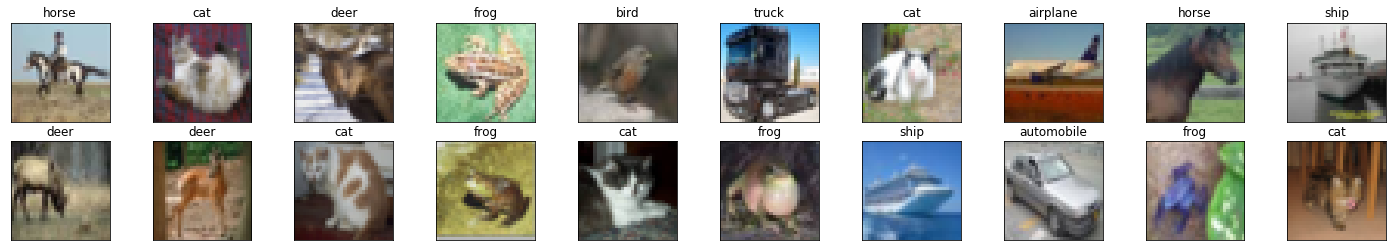

In [8]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
#display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2, idx+1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

### View and Image in More detail
Here, we look at normalized red, green and blue (RGB) color channels as three separate, grayscale intensity images

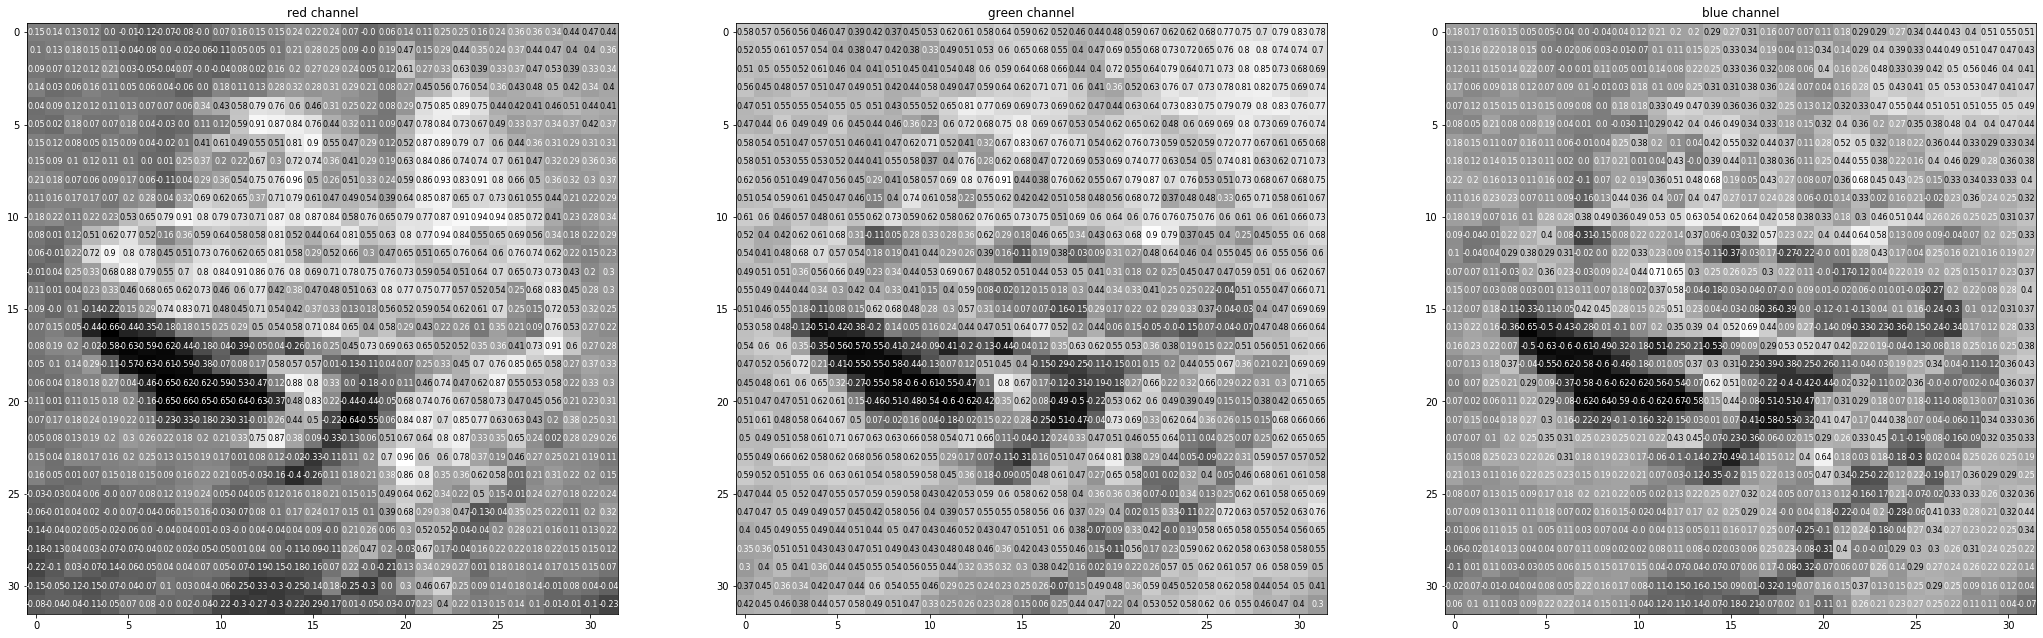

In [13]:
rgb_img = np.squeeze(images[3])
channels = ['red channel','green channel','blue channel']

fig = plt.figure(figsize=(36,36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1,3,idx+1)
  img = rgb_img[idx]
  ax.imshow(img,cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] != 0 else 0
      ax.annotate(str(val),xy = (y,x),
                  horizontalalignment = 'center',
                  verticalalignment = 'center', size = 8,
                  color = 'white' if img[x][y]<thresh else 'black')

## Deine the Network Architecture
This code defines a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, the following components will be used:

- Convolutional layers, which can be thought of as stack of filtered images.
- Maxpooling layers, which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
- The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

### Output Volume for a convolutional layer
To compute the size of a given Convolutional layer, we can perform the following calculation. 

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W  is given by (W-F+2P)/S+1

For example, a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2, we would get a 3x3 output.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

#Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3,16,3,padding =1)
        # Convolution layer ( sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16,32,3, padding = 1)
        # Convolution layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32,64,3,padding =1)
        #max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # linear layer (64*4*4 -> 500)
        self.fc1 = nn.Linear(64*4*4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500,10)
        # Dropout layer (p =  0.35)
        self.dropout = nn.Dropout(0.35)
    
    def forward(self,x):
        # add a sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input 
        x = x.view(-1,64*4*4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function 
        x = self.fc2(x)
        return x
#create a complete CNN
model = Net()
print(model)

#Move tensors to GPU is CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)


## Specify Loss Function and Optimizer

Decide on a loss optimization function that is best suited for this calssification task.

In [0]:
import torch.optim as optim 

# Specify loss function (categorical cross entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

## Train the optimizer

In [38]:
# Number of epochs to train the model
n_epochs = 50
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    
    #Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    #train the model#
    #################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(),target.cuda()
        # Clear the grdients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass; compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ####################
    #Validate the model#
    ####################
    model.eval()
    for data, target in valid_loader:
        # move the data to GPU if available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output,target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        
    #calculate average losss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
    epoch, train_loss,valid_loss))
    
    # save model if validation loss has dcreased
    if valid_loss <=valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}). Saving Model ...".format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.542322	Validation Loss: 0.669856
Validation loss decreased (inf --> 0.669856). Saving Model ...
Epoch: 2 	Training Loss: 0.529393	Validation Loss: 0.669365
Validation loss decreased (0.669856 --> 0.669365). Saving Model ...
Epoch: 3 	Training Loss: 0.506768	Validation Loss: 0.668884
Validation loss decreased (0.669365 --> 0.668884). Saving Model ...
Epoch: 4 	Training Loss: 0.504667	Validation Loss: 0.664346
Validation loss decreased (0.668884 --> 0.664346). Saving Model ...
Epoch: 5 	Training Loss: 0.486837	Validation Loss: 0.674626
Epoch: 6 	Training Loss: 0.478402	Validation Loss: 0.666524
Epoch: 7 	Training Loss: 0.467369	Validation Loss: 0.661582
Validation loss decreased (0.664346 --> 0.661582). Saving Model ...
Epoch: 8 	Training Loss: 0.459270	Validation Loss: 0.663410
Epoch: 9 	Training Loss: 0.444867	Validation Loss: 0.658139
Validation loss decreased (0.661582 --> 0.658139). Saving Model ...
Epoch: 10 	Training Loss: 0.436725	Validation Loss: 0.677